In [1]:
import pandas as pd

# CSV 파일에서 데이터 읽기
# df = pd.read_csv('Data/using/dt_2.6/ByAstar_dt_2.6_modified.csv')
# df = pd.read_csv('Local_Optimizer/LO_results_dir/ByLO_dt_None_20231128_150644.csv')
# df = pd.read_csv('Local_Optimizer/LO_results_dir/ByLO_dt_change_20231129_174617.csv')
df = pd.read_csv('Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')

df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29528 entries, 0 to 29527
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gate length     29528 non-null  int64  
 1   Theta           29528 non-null  float64
 2   Phi             29528 non-null  float64
 3   dt              29528 non-null  float64
 4   combination     29528 non-null  object 
 5   total time      29528 non-null  float64
 6   computing time  29528 non-null  float64
 7   Case            4106 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ MB


array([[<Axes: title={'center': 'gate length'}>,
        <Axes: title={'center': 'Theta'}>],
       [<Axes: title={'center': 'Phi'}>, <Axes: title={'center': 'dt'}>],
       [<Axes: title={'center': 'total time'}>,
        <Axes: title={'center': 'computing time'}>]], dtype=object)

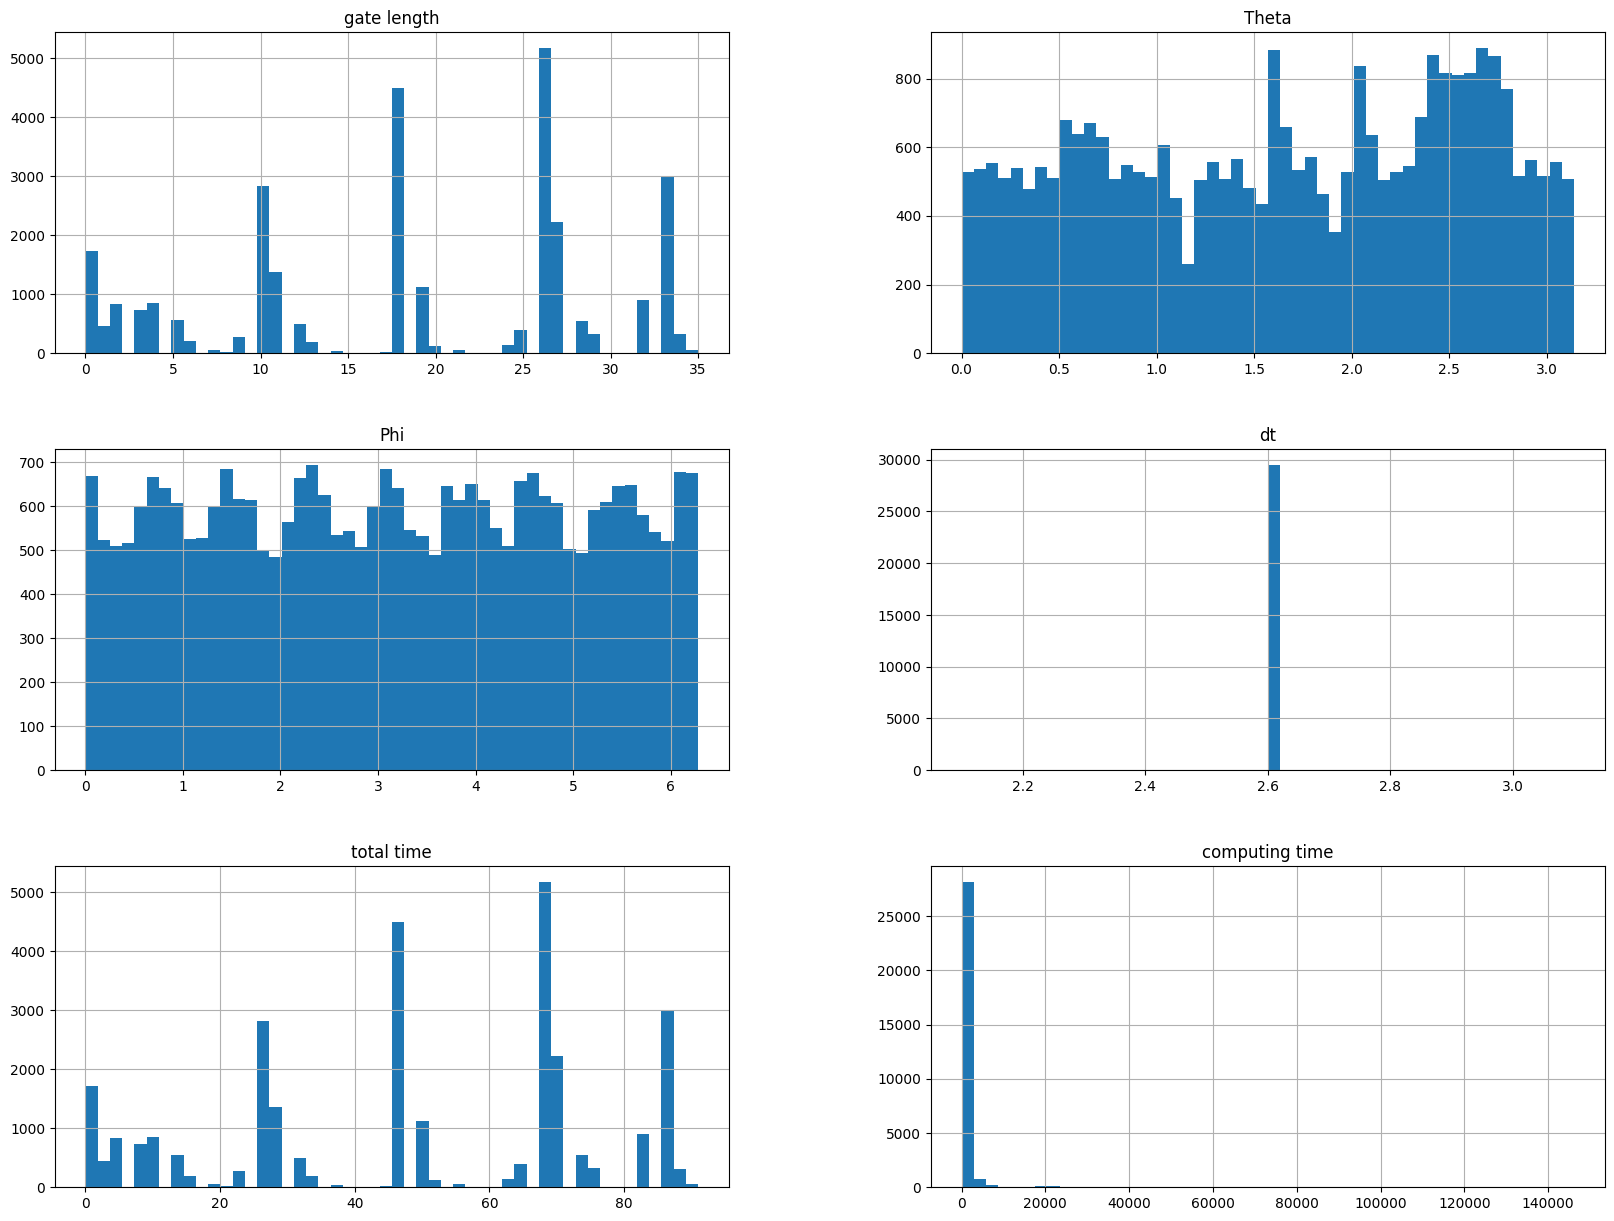

In [2]:
import matplotlib as plt

%matplotlib inline
df.hist(bins=50, figsize=(20,15))

# 히스토그램(주어진 값 범위 수평축, 샘플 수 수직축)

<Axes: xlabel='Theta', ylabel='Phi'>

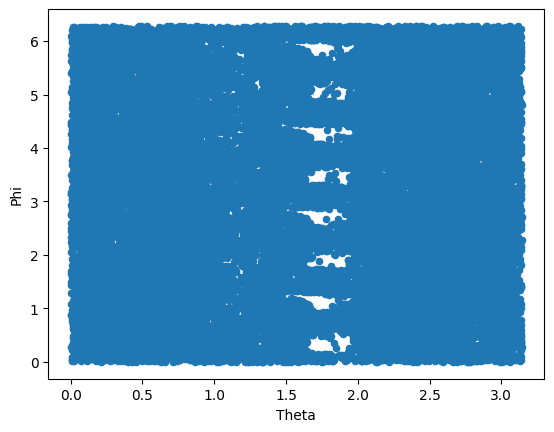

In [3]:
df.plot(kind = "scatter", x="Theta", y="Phi", alpha=1)

In [6]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi, input_seq):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    # predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in input_seq:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [7]:
# theta와 phi 값들을 numpy 배열로 변환
thetas = df['Theta'].to_numpy()
phis = df['Phi'].to_numpy()
lists = df['combination']

sum = 0
iter = len(thetas)
num = 0
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

# theta와 phi 값들을 반복하며 fidelity 계산
for target_theta, target_phi, input_sequence in zip(thetas, phis, lists):  
     
     input_sequence = eval(input_sequence)
     
     temp = fidelity(target_theta, target_phi, input_sequence)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp
     
     num += 1
     print(num, "/", iter)

print(sum/iter)

1 / 29528
2 / 29528
3 / 29528
4 / 29528
5 / 29528
6 / 29528
7 / 29528
8 / 29528
9 / 29528
10 / 29528
11 / 29528
12 / 29528
13 / 29528
14 / 29528
15 / 29528
16 / 29528
17 / 29528
18 / 29528
19 / 29528
20 / 29528
21 / 29528
22 / 29528
23 / 29528
24 / 29528
25 / 29528
26 / 29528
27 / 29528
28 / 29528
29 / 29528
30 / 29528
31 / 29528
32 / 29528
33 / 29528
34 / 29528
35 / 29528
36 / 29528
37 / 29528
38 / 29528
39 / 29528
40 / 29528
41 / 29528
42 / 29528
43 / 29528
44 / 29528
45 / 29528
46 / 29528
47 / 29528
48 / 29528
49 / 29528
50 / 29528
51 / 29528
52 / 29528
53 / 29528
54 / 29528
55 / 29528
56 / 29528
57 / 29528
58 / 29528
59 / 29528
60 / 29528
61 / 29528
62 / 29528
63 / 29528
64 / 29528
65 / 29528
66 / 29528
67 / 29528
68 / 29528
69 / 29528
70 / 29528
71 / 29528
72 / 29528
73 / 29528
74 / 29528
75 / 29528
76 / 29528
77 / 29528
78 / 29528
79 / 29528
80 / 29528
81 / 29528
82 / 29528
83 / 29528
84 / 29528
85 / 29528
86 / 29528
87 / 29528
88 / 29528
89 / 29528
90 / 29528
91 / 29528
92 / 295

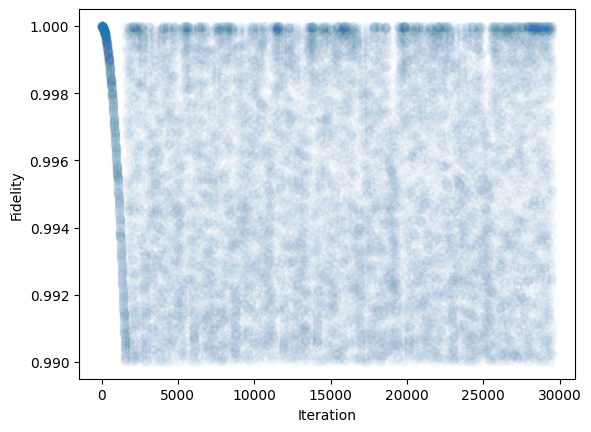

In [10]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.01)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [11]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.9999:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

139 0.9998984955124599
140 0.9998982755996011
141 0.9998963920463498
142 0.9998960830584661
143 0.9998959891965087
144 0.9998938570671826
145 0.9998931709083683
146 0.9998920518883887
147 0.9998919239484834
148 0.9998885468502174
149 0.999888493459357
150 0.9998859213783148
151 0.9998851469753306
152 0.9998836427279848
153 0.9998826517847861
154 0.9998818938342873
155 0.9998774372469207
156 0.9998757806552977
157 0.9998735903163344
158 0.9998721610433223
159 0.9998714527928099
160 0.9998691616087237
161 0.9998656135185829
162 0.9998653535757737
163 0.9998638438162378
164 0.9998615794322694
165 0.9998608837778608
166 0.9998602962219719
167 0.9998602458811282
168 0.9998597550593625
169 0.9998568486932405
170 0.9998568249442531
171 0.999856534113829
172 0.9998560799156032
173 0.9998560626411239
174 0.9998545551666088
175 0.9998453571965173
176 0.9998448426364951
177 0.9998406101048805
178 0.9998328352894638
179 0.999831701216971
180 0.9998316816288167
181 0.9998306599779512
182 0.99982953

In [ ]:
# df.plot(kind = "scatter", x="Case", y="fidelity", alpha=1)

# print(df['fidelity'].mean())

In [ ]:
# df2 = df[df['fidelity'] > 0.9999]

# print(df2['fidelity'].mean())
# df2.info()

In [ ]:
# df3 = df[df['fidelity'] < 0.9999]

# print(df3['fidelity'].mean())
# df3.info()